# Setup

## Abre diretório do Google Drive

In [ ]:
# drive.mount('/content/drive')
# %cd /content/drive/"My Drive"/'Colab Notebooks'/python-movie-analysis/curtas-tec-cine
# !ls

In [13]:
# !cd curtas-tec-cine
# !dir

## Importa as bibliotecas usadas

In [1]:
import face_recognition
import cv2
import numpy as np
import argparse
import os
import pandas as pd
import datetime
import csv
import time
import ffmpeg
from os import walk
import glob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sys
import math
import unidecode
import random
import moviepy.editor as mp
import librosa
import IPython.display as ipd
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import pyaudio
from vosk import Model, KaldiRecognizer, SetLogLevel
import wave
import subprocess
import json
import speech_recognition as sr
import pydub
from wordcloud import WordCloud, ImageColorGenerator
from fer import FER
from fer import Video
import cv2
import pandas as pd
import numpy as np
from __future__ import print_function
import os

# Standard PySceneDetect imports:
from scenedetect.video_manager import VideoManager
from scenedetect.scene_manager import SceneManager
# For caching detection metrics and saving/loading to a stats file
from scenedetect.stats_manager import StatsManager

# For content-aware scene detection:
from scenedetect.detectors.content_detector import ContentDetector
# from google.colab import drive

## Reduz FPS (ajuda na análise)

In [3]:
# Gera uma cópia do vídeo fornecido, só que a 3 fps

#Vários arquivos

for filepath in glob.iglob('curtas-tec-cine/*.m4v'):
    # print(filepath)
    videoname = str(filepath).replace(".m4v","")
    stream = ffmpeg.input(str(filepath))
    stream = stream.filter('fps', fps=1)
    stream = ffmpeg.output(stream, videoname + '-1fps.mp4')
    ffmpeg.run(stream)

# Um arquivo

# videoname = 'curtas-tec-cine/DAVI E OS AVIÕES'
# stream = ffmpeg.input(videoname+".m4v")
# stream = stream.filter('fps', fps=1)
# stream = ffmpeg.output(stream, videoname + '-1fps.mp4')
# ffmpeg.run(stream)

## Armazena títulos e duração

In [3]:
titulos = []
duracao = []

for filepath in glob.iglob('curtas-tec-cine/*-1fps.mp4'):
    video_capture = cv2.VideoCapture(str(filepath))
    videoname = str(filepath).replace("-1fps.mp4","")
    videoname = videoname.replace("curtas-tec-cine\\","")
    videoname = videoname.capitalize()
    print(videoname,"|", video_capture.get(cv2.CAP_PROP_FRAME_COUNT),"segundos" )
    titulos.append(videoname)
    duracao.append(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    
    
# video_capture = cv2.VideoCapture(videoname+ '-3fps.mp4')
# print("FPS:",video_capture.get(cv2.CAP_PROP_FPS))
# print("Número de frames do vídeo:",video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

A céu aberto | 444.0 segundos
Aqui jazz | 505.0 segundos
Como enfrentar os desafios da vida moderna | 512.0 segundos
Davi e os aviões | 689.0 segundos
Depois da pele | 830.0 segundos
Maresia | 546.0 segundos
O cão | 560.0 segundos
O retorno da lua | 634.0 segundos
Quarto de espera | 753.0 segundos
Roda gigante | 880.0 segundos
Tricô e pitangas | 563.0 segundos


## Gera gráfico com a duração em minutos e frames

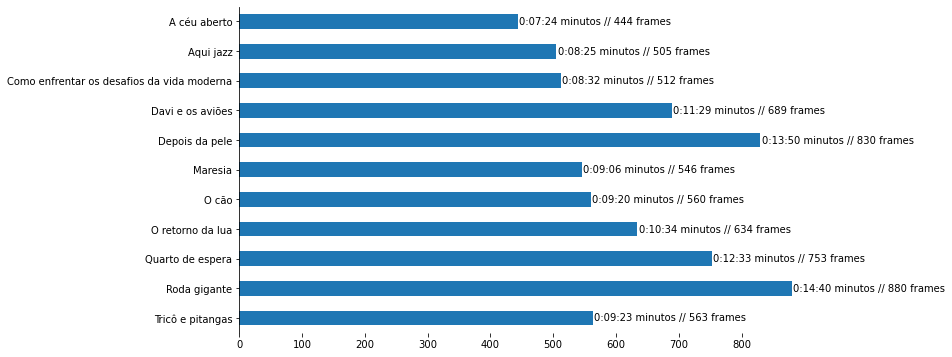

In [14]:
plot_duracao = pd.DataFrame(list(zip(titulos,duracao)), index=titulos).sort_values(0, ascending=False)
                            
                            
top = plot_duracao.plot(kind='barh', 
                        colormap='tab10', 
                        figsize=(10, 6))    

for i, v in enumerate(list(plot_duracao[1])):
    top.text(v+2, i-.10, "{:0>1}".format(str(datetime.timedelta(seconds=v))+" minutos // "+ str(int(v))+" frames"), color='black')

    
top.margins(x=0.01)
top.spines['right'].set_visible(False)
top.spines['top'].set_visible(False)
top.spines['bottom'].set_visible(False)
    
top.get_legend().remove()            

plt.savefig("Figura 0 - Duracao Curtas.jpg",bbox_inches = 'tight')

# Detecção de Faces

## Armazena o tempo que faces aparecem em cada curta

In [129]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

percentual_faces = []
titulos = []
frames_faces_v = []
frames_totais_v = []

for filepath in glob.iglob('curtas-tec-cine/*-1fps.mp4'):
    videoname = str(filepath).replace("-1fps.mp4","")
    videoname = videoname.replace("curtas-tec-cine\\","")
    titulos.append(videoname.capitalize())
    cap = cv2.VideoCapture(str(filepath))
    
    frame_faces = 0
    frames_totais = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_atual = 0

    while frame_atual < frames_totais:
        _, img = cap.read()
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Detect the faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        if len(faces)!= 0:
            frame_faces = frame_faces  + 1  
        # # Draw the rectangle around each face
        # for (x, y, w, h) in faces:
        #     cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        # # Display
        # cv2.imshow('img', img)
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break
        frame_atual = frame_atual + 1
    # cap.release()
    # print(videoname.capitalize(),round(frame_faces/frames_totais,4)*100)
    frames_faces_v.append(frame_faces)
    frames_totais_v.append(frames_totais)
    percentual_faces.append(round(frame_faces/frames_totais,2)*100)
    

In [130]:
percentual_faces = [round(v,2) for v in percentual_faces]
percentual_faces

plot_reasons = [100-x for x in percentual_faces]
plot_reasons

[94.0, 78.0, 38.0, 90.0, 68.0, 78.0, 66.0, 43.0, 88.0, 46.0, 42.0]

In [3]:
# cap = cv2.VideoCapture("curtas-tec-cine/COMO ENFRENTAR OS DESAFIOS DA VIDA MODERNA-1fps.mp4")
# frames_totais = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# frame_atual = 0 
# face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    
# while frame_atual < frames_totais:
#     _, img = cap.read()
#     # Convert to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     # Detect the faces
#     faces = face_cascade.detectMultiScale(gray, 1.1, 4)
#     # Draw the rectangle around each face
#     for (x, y, w, h) in faces:
#         cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
#     # Display
#     cv2.imshow('img', img)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
#     frame_atual = frame_atual + 1
# cap.release()

In [134]:
plot_percentual = pd.DataFrame(list(zip(percentual_faces,plot_reasons)), index=titulos)
plot_percentual

plot_percentual = plot_percentual.sort_index(ascending=False)
# plot_percentual = plot_percentual.sort_values(index, ascending=True)
# cross_tab_prop

plot_percentual


,0,1
Tricô e pitangas,58.0,42.0
Roda gigante,54.0,46.0
Quarto de espera,12.0,88.0
O retorno da lua,57.0,43.0
O cão,34.0,66.0
Maresia,22.0,78.0
Depois da pele,32.0,68.0
Davi e os aviões,10.0,90.0
Como enfrentar os desafios da vida moderna,62.0,38.0
Aqui jazz,22.0,78.0


## Gera gráfico com percentual de aparição de faces

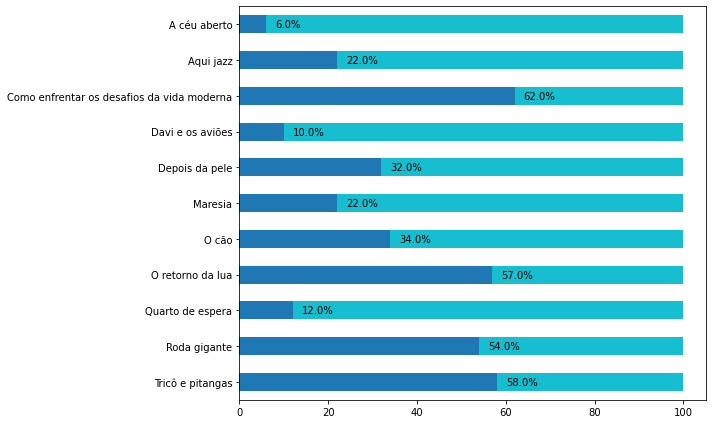

In [136]:

top = plot_percentual.plot(kind='barh', 
                        stacked=True, 
                        colormap='tab10', 
                        figsize=(10, 6))

# plt.legend(loc="lower left", ncol=2)
# plt.ylabel("Release Year")
# plt.xlabel("Proportion")


# for n, x in enumerate([*cross_tab.index.values]):
#     for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
#                                           cross_tab.loc[x],
#         

for i, v in enumerate(list(plot_percentual[0])):
    top.text(v+2, i-.09, str(v)+"%", color='black')
    
    
top.get_legend().remove()   

# cross_tab_prop.loc[x].cumsum()):
                
        # plt.text(x=(y_loc - proportion) + (proportion / 2),
        #          y=n - 0.11,
        #          s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
        #          color="black",
        #          fontsize=12,
        #          fontweight="bold")

# plt.show()
plt.tight_layout()
plt.savefig("Figura 11 - Detecção de Faces nos Curtas.jpg",bbox_inches = 'tight')

# Detecção de Cores

## Declara funções de redução de tamanho e detecção de cores

In [52]:
def image_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation=inter)
    return resized


def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    # return the histogram
    return hist

def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    # Sort the centroids to form a gradient color look
    centroids = sorted(centroids, key=lambda x: sum(x))

    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids[offset:]):
        # plot the relative percentage of each cluster
        # endX = startX + (percent * 300)

        # Instead of plotting the relative percentage,
        # we will make a n=clusters number of color rectangles
        # we will also seperate them by a margin
        new_length = 300 - margin * (clusters - 1)
        endX = startX + new_length/clusters
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        cv2.rectangle(bar, (int(endX), 0), (int(endX + margin), 50),
                      (255, 255, 255), -1)
        startX = endX + margin

    # return the bar chart
    return bar

## Salva os frames como imagens

In [ ]:
for filepath in glob.iglob('curtas-tec-cine/*-1fps.mp4'):
    videoname = str(filepath).replace("-1fps.mp4","")
    videoname = videoname.replace("curtas-tec-cine\\","")
    videoname = unidecode.unidecode(videoname)
    directory = "curtas-tec-cine/"+videoname+"/"
    if not os.path.exists(directory):
        os.makedirs(directory)
        cap = cv2.VideoCapture(str(filepath))
        count = 0
        frameRate = cap.get(5)
        x=1
        while(cap.isOpened()):
            frameId = cap.get(1) #current frame number
            ret, frame = cap.read()
            if (ret != True):
                break
            if (frameId % math.floor(frameRate) == 0):

                filename = directory+str(count)+" - "+videoname+".jpg"
                
                count+=1
                cv2.imwrite(filename, frame)
                # print(filename)
        cap.release()
        # print ("Done!")

## Seleciona randômicamente um frame e executa a função de detecção de cores

In [51]:
directories = []
for filepath in glob.iglob('curtas-tec-cine/*-1fps.mp4'):
    videoname = str(filepath).replace("-1fps.mp4","")
    videoname = videoname.replace("curtas-tec-cine\\","")
    videoname = unidecode.unidecode(videoname)
    directories.append("curtas-tec-cine/"+videoname+"/")
    


filepaths1 = []
for d in directories:
    filepaths2 = []
    for filepath in glob.iglob(d+"*.jpg"):
        filepaths2.append(filepath)
    filepaths1.append(filepaths2[random.randint(300,400)])
    
filepaths1


['curtas-tec-cine/A CEU ABERTO\\42 - A CEU ABERTO.jpg',
 'curtas-tec-cine/AQUI JAZZ\\409 - AQUI JAZZ.jpg',
 'curtas-tec-cine/COMO ENFRENTAR OS DESAFIOS DA VIDA MODERNA\\410 - COMO ENFRENTAR OS DESAFIOS DA VIDA MODERNA.jpg',
 'curtas-tec-cine/DAVI E OS AVIOES\\453 - DAVI E OS AVIOES.jpg',
 'curtas-tec-cine/DEPOIS DA PELE\\371 - DEPOIS DA PELE.jpg',
 'curtas-tec-cine/MARESIA\\428 - MARESIA.jpg',
 'curtas-tec-cine/O CAO\\437 - O CAO.jpg',
 'curtas-tec-cine/O RETORNO DA LUA\\389 - O RETORNO DA LUA.jpg',
 'curtas-tec-cine/QUARTO DE ESPERA\\399 - QUARTO DE ESPERA.jpg',
 'curtas-tec-cine/RODA GIGANTE\\389 - RODA GIGANTE.jpg',
 'curtas-tec-cine/TRICO E PITANGAS\\433 - TRICO E PITANGAS.jpg']

In [53]:
# Global variables

for x,f in enumerate(filepaths1):

    framesTaken = 0
    framesTakenList = []
    framesSpecified = 0
    clusters = 5
    margin = 5
    borderSize = 60
    offset = 2

    # We define our custom VLC Player class

    # Let's fetch the video frame we just captured
    imagePath = "vidamoderna.png"
    # Transform the image to an OpenCV readable image
    image = cv2.imread(f)

    # Let's make a copy of this image
    # to use for the color palette generation
    image_copy = image_resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), width=100)

    # Since the K-means algorithm we're about to do,
    # is very labour intensive, we will do it on a smaller image copy
    # This will not affect the quality of the algorithm
    pixelImage = image_copy.reshape(
        (image_copy.shape[0] * image_copy.shape[1], 3))

    # We use the sklearn K-Means algorithm to find the color histogram
    # from our small size image copy
    clt = KMeans(n_clusters=clusters+offset)
    clt.fit(pixelImage)

    # build a histogram of clusters and then create a figure
    # representing the number of pixels labeled to each color
    hist = centroid_histogram(clt)

    # Let's plot the retrieved colors. See the plot_colors function
    # for more details
    bar = plot_colors(hist, clt.cluster_centers_)

    # Resize the color bar to be even width with the video frame
    barImage = image_resize(
        cv2.cvtColor(bar, cv2.COLOR_RGB2BGR),width=720)
    newImg = np.concatenate([image, barImage], axis=0)
    # Now we combine the video frame and the color bar into one image
    # newImg = np.concatenate([image, im, barImage], axis=0)
    cv2.imwrite("paletas-"+titulos[x]+".jpg", newImg)
     # cv2.imwrite("result_image.png", base)

In [56]:
framesTaken = 0
framesTakenList = []
framesSpecified = 0
clusters = 5
margin = 5
borderSize = 60
offset = 2

# We define our custom VLC Player class

# Let's fetch the video frame we just captured
imagePath = "225 - A CEU ABERTO.jpg"
# Transform the image to an OpenCV readable image
image = cv2.imread(imagepath)

# Let's make a copy of this image
# to use for the color palette generation
image_copy = image_resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), width=100)

# Since the K-means algorithm we're about to do,
# is very labour intensive, we will do it on a smaller image copy
# This will not affect the quality of the algorithm
pixelImage = image_copy.reshape(
    (image_copy.shape[0] * image_copy.shape[1], 3))

# We use the sklearn K-Means algorithm to find the color histogram
# from our small size image copy
clt = KMeans(n_clusters=clusters+offset)
clt.fit(pixelImage)

# build a histogram of clusters and then create a figure
# representing the number of pixels labeled to each color
hist = centroid_histogram(clt)

# Let's plot the retrieved colors. See the plot_colors function
# for more details
bar = plot_colors(hist, clt.cluster_centers_)

# Resize the color bar to be even width with the video frame
barImage = image_resize(
    cv2.cvtColor(bar, cv2.COLOR_RGB2BGR),width=720)
newImg = np.concatenate([image, barImage], axis=0)
# Now we combine the video frame and the color bar into one image
# newImg = np.concatenate([image, im, barImage], axis=0)
cv2.imwrite("paletas-aceuaberto.jpg", newImg)
 # cv2.imwrite("result_image.png", base)


NameError: name 'imagepath' is not defined

In [1]:
!pip install scenedetect[opencv]

You should consider upgrading via the 'D:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


# Detecção de Cenas

## Carrega e executa a bibilioteca PySceneDetect

In [4]:
numero_cenas = []
duracao_cenas_v = []
titulos = []

for filepath in glob.iglob('curtas-tec-cine/*-1fps.mp4'):
    duracao_cenas = []
    videoname = str(filepath).replace("-1fps.mp4","")
    videoname = videoname.replace("curtas-tec-cine\\","")
    titulos.append(videoname.capitalize())
    video_path = str(filepath)
    # type: (str) -> List[Tuple[FrameTimecode, FrameTimecode]]
    # Construct our SceneManager and pass it our StatsManager.
    # Add ContentDetector algorithm (each detector's constructor
    video_manager = VideoManager([video_path])
    stats_manager = StatsManager()
    scene_manager = SceneManager(stats_manager)
    scene_manager.add_detector(ContentDetector())
    scene_list = []
    # If stats file exists, load it.
    # Set downscale factor to improve processing speed.
    # Start video_manager.
    # Perform scene detection on video_manager.
    video_manager.set_downscale_factor()
    video_manager.start()
    scene_manager.detect_scenes(frame_source=video_manager)

    # Obtain list of detected scenes.
    scene_list = scene_manager.get_scene_list()
    for i, scene in enumerate(scene_list):
        duracao_cenas.append(scene[1].get_frames() - scene[0].get_frames())
    duracao_cenas_v.append(duracao_cenas)
    
    # Each scene is a tuple of (start, end) FrameTimecodes.

    # We only write to the stats file if a save is required:
    # if stats_manager.is_save_required():
    #     base_timecode = video_manager.get_base_timecode()
    #     with open(stats_file_path, 'w') as stats_file:
    #         stats_manager.save_to_csv(stats_file, base_timecode)
    video_manager.release()
    numero_cenas.append(len(scene_list))

# return scene_list

100%|███████████████████████████████████████████████████████████████████████████| 563/563 [00:01<00:00, 293.26frames/s]


In [175]:
# duracao_cenas = []
# duracao_cenas_v = []

# video_path = "curtas-tec-cine/AQUI JAZZ.m4v"
# # type: (str) -> List[Tuple[FrameTimecode, FrameTimecode]]
# # Construct our SceneManager and pass it our StatsManager.
# # Add ContentDetector algorithm (each detector's constructor
# video_manager = VideoManager([video_path])
# stats_manager = StatsManager()
# scene_manager = SceneManager(stats_manager)
# scene_manager.add_detector(ContentDetector())
# scene_list = []
# # If stats file exists, load it.
# # Set downscale factor to improve processing speed.
# # Start video_manager.
# # Perform scene detection on video_manager.
# video_manager.set_downscale_factor()
# video_manager.start()
# scene_manager.detect_scenes(frame_source=video_manager)

# # Obtain list of detected scenes.
# scene_list = scene_manager.get_scene_list()
# # Each scene is a tuple of (start, end) FrameTimecodes.
# for i, scene in enumerate(scene_list):
#     duracao_cenas.append(scene[1].get_frames() - scene[0].get_frames())


# # We only write to the stats file if a save is required:
# # if stats_manager.is_save_required():
# #     base_timecode = video_manager.get_base_timecode()
# #     with open(stats_file_path, 'w') as stats_file:
# #         stats_manager.save_to_csv(stats_file, base_timecode)

# video_manager.release()

# len(duracao_cenas)

# # return scene_list

100%|███████████████████████████████████████████████████████████████████████| 15140/15140 [00:54<00:00, 277.44frames/s]


6

## Gera gráfico com o número de cenas

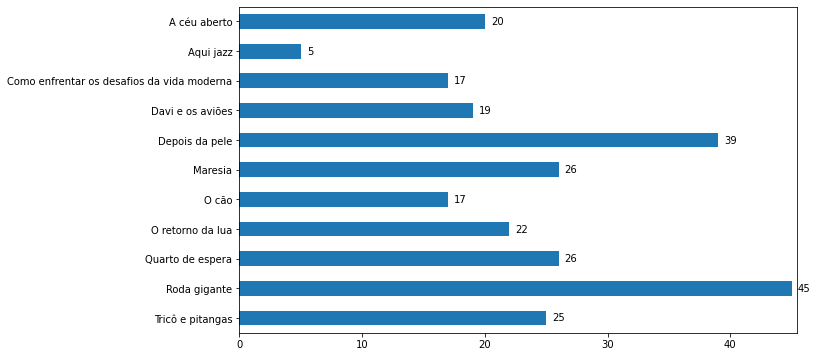

In [172]:
plot_duracao = pd.DataFrame(list(zip(titulos,numero_cenas)), index=titulos).sort_values(0, ascending=False)
                            
                            
top = plot_duracao.plot(kind='barh', 
                        colormap='tab10', 
                        figsize=(10, 6))    

for i, v in enumerate(list(plot_duracao[1])):
    top.text(v+0.5, i-.1, v , color='black')

    
top.margins(x=0.01)
# top.spines['right'].set_visible(False)
# top.spines['top'].set_visible(False)
# top.spines['bottom'].set_visible(False)
    
top.get_legend().remove()            

plt.savefig("Figura 002 - Número de Cenas.jpg",bbox_inches = 'tight')

In [33]:
pdCenas = pd.DataFrame(list(zip(duracao_cenas_v)), index=titulos)
pdCenas = pd.DataFrame(pdCenas[0].to_list(),index=titulos)
pdCenas = pdCenas.sort_index(ascending= False) 

## Gera gráfico com a duração das cenas

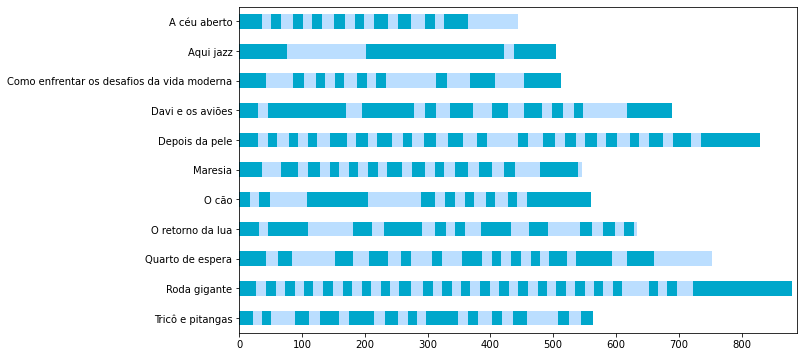

In [42]:
cenas =  pdCenas.plot(kind='barh', 
                    stacked=True, 
                    color=['#00A7CB', '#BBDEFF'],
                    figsize=(10, 6))

cenas.margins(x=0.01)

cenas.get_legend().remove()

plt.savefig("Figura 003 - Duração de Cenas.jpg",bbox_inches = 'tight')

## Extraí o áudio dos curtas

In [33]:
for filepath in glob.iglob('curtas-tec-cine/*.m4v'):
    videoname = str(filepath).replace("-1fps.mp4","")
    videoname = videoname.replace("curtas-tec-cine\\","")
    videoname = unidecode.unidecode(videoname)
    clip = mp.VideoFileClip(str(filepath))
    clip.audio.write_audiofile("AUDIO-"+ videoname+".wav")
    print(videoname)

A CEU ABERTO.m4v
AQUI JAZZ.m4v
COMO ENFRENTAR OS DESAFIOS DA VIDA MODERNA.m4v
DAVI E OS AVIOES.m4v
DEPOIS DA PELE.m4v
MARESIA.m4v
O CAO.m4v
O RETORNO DA LUA.m4v
QUARTO DE ESPERA.m4v
RODA GIGANTE.m4v
TRICO E PITANGAS.m4v


## Detecta destaques nos áudios

In [4]:
for filename in glob.iglob('*.wav'):
    
    videoname = str(filename).replace(".wav","")
    videoname = videoname.replace(".m4v","")
    # Load the file
    x, sr = librosa.load(filename, sr=16000)
    int(librosa.get_duration(x, sr) / 60)

    # Create chunks for 10 secs
    max_slice = 10
    window_length = max_slice * sr
    a = x[21 * window_length:22 * window_length]
    ipd.Audio(a, rate=sr)

    # Calculate the energy
    energy = sum(abs(a ** 2))
    print(energy)

    # Calculate the energy for each chunk
    energy = np.array([sum(abs(x[i:i + window_length] ** 2)) for i in range(0, len(x), window_length)])

    # Plot the above thing
    plt.plot(energy)
    
    grafico = "GRAFICO-"+videoname+".jpg"
    plt.savefig(grafico,bbox_inches = 'tight')
    plt.clf()

113.72293351682309
1789.098816083973
1937.427647310141
5.974270547096832
16.785078734684475
6.132338434332608
280.54753041909953
98.00855516123006
861.4823711946533
991.16039025353
15.49712490183876


<Figure size 432x288 with 0 Axes>

# Detecção de Narrativas

In [3]:
videonames = []

for filename in glob.iglob('AUDIO*.wav'):
    videoname = str(filename).replace(".wav","")
    videoname = videoname.replace(".m4v","")
    videoname = videoname.replace("AUDIO-","")
    videonames.append(videoname)
    s1 = pydub.AudioSegment.from_file(str(filename), format="wav")
    sound = s1.set_channels(1)
    sound.export(videoname+"-mono.wav", format="wav")


## Faz reconhecimento de falas

In [4]:

textos = []

for filename in glob.iglob('*.wav'):
    wf = wave.open(filename, "rb")
    if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
        print ("Audio file must be WAV format mono PCM.")
        exit (1)

    model = Model("model")
    rec = KaldiRecognizer(model, wf.getframerate())
    rec.SetWords(True)

    text_lst =[]
    p_text_lst = []
    p_str = []
    len_p_str = []
    while True:
        data = wf.readframes(4000)
        if len(data) == 0:
            break
        if rec.AcceptWaveform(data):
            text_lst.append(rec.Result())
            # print(rec.Result())
        else:
            p_text_lst.append(rec.PartialResult())
            # print(rec.PartialResult())


    novalista = [x for x in p_text_lst if not """{\n  "partial" : ""\n}""" in x]


    novalista = [w.replace("""{\n  "partial" : """, '') for w in novalista]
    novalista = [w.replace("""\n}""", '') for w in novalista]
    novalista = [w.replace('"', '') for w in novalista]

    texto = " ".join(novalista)
    # print(texto)
    textos.append(texto)

    # novalista

    # txt_str

In [11]:
# textos[4]
f = open("stopwords.txt", 'r', encoding='utf-8')
stopwords = [name.rstrip().lower() for name in f]

## Gera tagclouds com as palavras mais utilizadas

In [ ]:
for ix,texto in enumerate(textos):
    
    if ix != 5:
        wordcloud = WordCloud(
            width = 3000,
            height = 2000,
            background_color = 'white',
            max_words=20,
            prefer_horizontal=1,
            stopwords=stopwords).generate(texto)
        fig = plt.figure(
            figsize = (40, 30),
            facecolor = 'k',
            edgecolor = 'k')
        plt.imshow(wordcloud, interpolation = 'bilinear')
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.savefig("tagcloud-"+videonames[ix]+".jpg",bbox_inches = 'tight')
        print(ix)
        plt.clf()

# Detecção de Emoções

## Gera gráficos com as emoções detectadas

In [10]:
for filepath in glob.iglob('curtas-tec-cine/*-1fps.mp4'):
    video_capture = cv2.VideoCapture(str(filepath))
    videoname = str(filepath).replace("-1fps.mp4","")
    videoname = videoname.replace("curtas-tec-cine\\","")
    videoname = unidecode.unidecode(videoname)
    detector = FER(mtcnn=True)
    video = Video(filepath)
    dados = video.analyze(detector, display=False, save_video=True, frequency=1, annotate_frames=False, save_frames=True)
    df = video.to_pandas(dados)
    detector = FER(mtcnn=True)
    df.plot() 
    grafico = "EMOCOES-"+videoname+".jpg"
    plt.savefig(grafico,bbox_inches = 'tight')
    plt.clf()

22-11-2021:23:19:24,887 INFO     [classes.py:199] 1.00 fps, 444 frames, 444.00 seconds
22-11-2021:23:19:24,887 INFO     [classes.py:207] Making directories at output


100%|████████████████████████████████████████████████████████████████████████████| 444/444 [04:35<00:00,  1.61frames/s]


22-11-2021:23:23:59,977 INFO     [classes.py:320] Completed analysis: saved to output\A CÉU ABERTO-1fps_output.mp4
22-11-2021:23:23:59,977 INFO     [classes.py:327] Starting to Zip
22-11-2021:23:24:00,242 INFO     [classes.py:338] Compressing: 11%
22-11-2021:23:24:00,494 INFO     [classes.py:338] Compressing: 22%
22-11-2021:23:24:00,775 INFO     [classes.py:338] Compressing: 33%
22-11-2021:23:24:01,101 INFO     [classes.py:338] Compressing: 45%
22-11-2021:23:24:01,350 INFO     [classes.py:338] Compressing: 56%
22-11-2021:23:24:01,582 INFO     [classes.py:338] Compressing: 67%
22-11-2021:23:24:01,819 INFO     [classes.py:338] Compressing: 78%
22-11-2021:23:24:02,186 INFO     [classes.py:338] Compressing: 90%
22-11-2021:23:24:02,400 INFO     [classes.py:339] Zip has finished
22-11-2021:23:24:03,657 INFO     [classes.py:199] 1.00 fps, 505 frames, 505.00 seconds
22-11-2021:23:24:03,658 INFO     [classes.py:207] Making directories at output
22-11-2021:23:24:03,659 INFO     [classes.py:352] 

100%|████████████████████████████████████████████████████████████████████████████| 505/505 [05:29<00:00,  1.53frames/s]


22-11-2021:23:29:33,9 INFO     [classes.py:320] Completed analysis: saved to output\AQUI JAZZ-1fps_output.mp4
22-11-2021:23:29:33,9 INFO     [classes.py:327] Starting to Zip
22-11-2021:23:29:33,292 INFO     [classes.py:338] Compressing: 9%
22-11-2021:23:29:33,533 INFO     [classes.py:338] Compressing: 19%
22-11-2021:23:29:33,787 INFO     [classes.py:338] Compressing: 29%
22-11-2021:23:29:34,19 INFO     [classes.py:338] Compressing: 39%
22-11-2021:23:29:34,269 INFO     [classes.py:338] Compressing: 49%
22-11-2021:23:29:34,514 INFO     [classes.py:338] Compressing: 59%
22-11-2021:23:29:34,756 INFO     [classes.py:338] Compressing: 69%
22-11-2021:23:29:35,20 INFO     [classes.py:338] Compressing: 79%
22-11-2021:23:29:35,290 INFO     [classes.py:338] Compressing: 89%
22-11-2021:23:29:35,519 INFO     [classes.py:338] Compressing: 99%
22-11-2021:23:29:35,553 INFO     [classes.py:339] Zip has finished
22-11-2021:23:29:36,821 INFO     [classes.py:199] 1.00 fps, 512 frames, 512.00 seconds
22-11

100%|████████████████████████████████████████████████████████████████████████████| 512/512 [06:34<00:00,  1.30frames/s]


22-11-2021:23:36:10,961 INFO     [classes.py:320] Completed analysis: saved to output\COMO ENFRENTAR OS DESAFIOS DA VIDA MODERNA-1fps_output.mp4
22-11-2021:23:36:10,962 INFO     [classes.py:327] Starting to Zip
22-11-2021:23:36:11,286 INFO     [classes.py:338] Compressing: 9%
22-11-2021:23:36:11,568 INFO     [classes.py:338] Compressing: 19%
22-11-2021:23:36:11,856 INFO     [classes.py:338] Compressing: 29%
22-11-2021:23:36:12,170 INFO     [classes.py:338] Compressing: 39%
22-11-2021:23:36:12,454 INFO     [classes.py:338] Compressing: 48%
22-11-2021:23:36:12,750 INFO     [classes.py:338] Compressing: 58%
22-11-2021:23:36:13,49 INFO     [classes.py:338] Compressing: 68%
22-11-2021:23:36:13,339 INFO     [classes.py:338] Compressing: 78%
22-11-2021:23:36:13,627 INFO     [classes.py:338] Compressing: 87%
22-11-2021:23:36:13,894 INFO     [classes.py:338] Compressing: 97%
22-11-2021:23:36:13,963 INFO     [classes.py:339] Zip has finished
22-11-2021:23:36:15,734 INFO     [classes.py:199] 1.00

100%|████████████████████████████████████████████████████████████████████████████| 689/689 [07:30<00:00,  1.53frames/s]


22-11-2021:23:43:46,555 INFO     [classes.py:320] Completed analysis: saved to output\DAVI E OS AVIÕES-1fps_output.mp4
22-11-2021:23:43:46,555 INFO     [classes.py:327] Starting to Zip
22-11-2021:23:43:46,855 INFO     [classes.py:338] Compressing: 7%
22-11-2021:23:43:47,102 INFO     [classes.py:338] Compressing: 14%
22-11-2021:23:43:47,346 INFO     [classes.py:338] Compressing: 21%
22-11-2021:23:43:47,589 INFO     [classes.py:338] Compressing: 29%
22-11-2021:23:43:47,837 INFO     [classes.py:338] Compressing: 36%
22-11-2021:23:43:48,106 INFO     [classes.py:338] Compressing: 43%
22-11-2021:23:43:48,361 INFO     [classes.py:338] Compressing: 50%
22-11-2021:23:43:48,625 INFO     [classes.py:338] Compressing: 58%
22-11-2021:23:43:48,873 INFO     [classes.py:338] Compressing: 65%
22-11-2021:23:43:49,123 INFO     [classes.py:338] Compressing: 72%
22-11-2021:23:43:49,374 INFO     [classes.py:338] Compressing: 79%
22-11-2021:23:43:49,629 INFO     [classes.py:338] Compressing: 87%
22-11-2021:2

100%|████████████████████████████████████████████████████████████████████████████| 830/830 [08:31<00:00,  1.62frames/s]


22-11-2021:23:52:22,642 INFO     [classes.py:320] Completed analysis: saved to output\DEPOIS DA PELE-1fps_output.mp4
22-11-2021:23:52:22,643 INFO     [classes.py:327] Starting to Zip
22-11-2021:23:52:22,930 INFO     [classes.py:338] Compressing: 6%
22-11-2021:23:52:23,184 INFO     [classes.py:338] Compressing: 12%
22-11-2021:23:52:23,429 INFO     [classes.py:338] Compressing: 18%
22-11-2021:23:52:23,695 INFO     [classes.py:338] Compressing: 24%
22-11-2021:23:52:23,963 INFO     [classes.py:338] Compressing: 30%
22-11-2021:23:52:24,217 INFO     [classes.py:338] Compressing: 36%
22-11-2021:23:52:24,474 INFO     [classes.py:338] Compressing: 42%
22-11-2021:23:52:24,728 INFO     [classes.py:338] Compressing: 48%
22-11-2021:23:52:24,991 INFO     [classes.py:338] Compressing: 54%
22-11-2021:23:52:25,232 INFO     [classes.py:338] Compressing: 60%
22-11-2021:23:52:25,491 INFO     [classes.py:338] Compressing: 66%
22-11-2021:23:52:25,741 INFO     [classes.py:338] Compressing: 72%
22-11-2021:23:

100%|████████████████████████████████████████████████████████████████████████████| 546/546 [06:05<00:00,  1.49frames/s]


22-11-2021:23:58:33,978 INFO     [classes.py:320] Completed analysis: saved to output\MARESIA-1fps_output.mp4
22-11-2021:23:58:33,978 INFO     [classes.py:327] Starting to Zip
22-11-2021:23:58:34,275 INFO     [classes.py:338] Compressing: 9%
22-11-2021:23:58:34,550 INFO     [classes.py:338] Compressing: 18%
22-11-2021:23:58:34,807 INFO     [classes.py:338] Compressing: 27%
22-11-2021:23:58:35,86 INFO     [classes.py:338] Compressing: 36%
22-11-2021:23:58:35,343 INFO     [classes.py:338] Compressing: 45%
22-11-2021:23:58:35,622 INFO     [classes.py:338] Compressing: 54%
22-11-2021:23:58:35,892 INFO     [classes.py:338] Compressing: 64%
22-11-2021:23:58:36,161 INFO     [classes.py:338] Compressing: 73%
22-11-2021:23:58:36,437 INFO     [classes.py:338] Compressing: 82%
22-11-2021:23:58:36,693 INFO     [classes.py:338] Compressing: 91%
22-11-2021:23:58:36,945 INFO     [classes.py:339] Zip has finished
22-11-2021:23:58:38,353 INFO     [classes.py:199] 1.00 fps, 560 frames, 560.00 seconds
22

100%|████████████████████████████████████████████████████████████████████████████| 560/560 [05:47<00:00,  1.61frames/s]


23-11-2021:00:04:25,685 INFO     [classes.py:320] Completed analysis: saved to output\O CÃO-1fps_output.mp4
23-11-2021:00:04:25,685 INFO     [classes.py:327] Starting to Zip
23-11-2021:00:04:25,985 INFO     [classes.py:338] Compressing: 8%
23-11-2021:00:04:26,245 INFO     [classes.py:338] Compressing: 17%
23-11-2021:00:04:26,500 INFO     [classes.py:338] Compressing: 26%
23-11-2021:00:04:26,763 INFO     [classes.py:338] Compressing: 35%
23-11-2021:00:04:27,30 INFO     [classes.py:338] Compressing: 44%
23-11-2021:00:04:27,286 INFO     [classes.py:338] Compressing: 53%
23-11-2021:00:04:27,546 INFO     [classes.py:338] Compressing: 62%
23-11-2021:00:04:27,793 INFO     [classes.py:338] Compressing: 71%
23-11-2021:00:04:28,34 INFO     [classes.py:338] Compressing: 80%
23-11-2021:00:04:28,277 INFO     [classes.py:338] Compressing: 89%
23-11-2021:00:04:28,532 INFO     [classes.py:338] Compressing: 98%
23-11-2021:00:04:28,585 INFO     [classes.py:339] Zip has finished
23-11-2021:00:04:29,798 I

100%|████████████████████████████████████████████████████████████████████████████| 634/634 [07:52<00:00,  1.34frames/s]


23-11-2021:00:12:22,339 INFO     [classes.py:320] Completed analysis: saved to output\O RETORNO DA LUA-1fps_output.mp4
23-11-2021:00:12:22,340 INFO     [classes.py:327] Starting to Zip
23-11-2021:00:12:22,633 INFO     [classes.py:338] Compressing: 7%
23-11-2021:00:12:22,930 INFO     [classes.py:338] Compressing: 15%
23-11-2021:00:12:23,242 INFO     [classes.py:338] Compressing: 23%
23-11-2021:00:12:23,591 INFO     [classes.py:338] Compressing: 31%
23-11-2021:00:12:23,879 INFO     [classes.py:338] Compressing: 39%
23-11-2021:00:12:24,210 INFO     [classes.py:338] Compressing: 47%
23-11-2021:00:12:24,490 INFO     [classes.py:338] Compressing: 55%
23-11-2021:00:12:24,784 INFO     [classes.py:338] Compressing: 63%
23-11-2021:00:12:25,85 INFO     [classes.py:338] Compressing: 70%
23-11-2021:00:12:25,396 INFO     [classes.py:338] Compressing: 78%
23-11-2021:00:12:25,681 INFO     [classes.py:338] Compressing: 86%
23-11-2021:00:12:25,957 INFO     [classes.py:338] Compressing: 94%
23-11-2021:00

100%|████████████████████████████████████████████████████████████████████████████| 753/753 [09:52<00:00,  1.27frames/s]


23-11-2021:00:22:20,689 INFO     [classes.py:320] Completed analysis: saved to output\QUARTO DE ESPERA-1fps_output.mp4
23-11-2021:00:22:20,689 INFO     [classes.py:327] Starting to Zip
23-11-2021:00:22:21,26 INFO     [classes.py:338] Compressing: 6%
23-11-2021:00:22:21,408 INFO     [classes.py:338] Compressing: 13%
23-11-2021:00:22:21,719 INFO     [classes.py:338] Compressing: 19%
23-11-2021:00:22:22,77 INFO     [classes.py:338] Compressing: 26%
23-11-2021:00:22:22,380 INFO     [classes.py:338] Compressing: 33%
23-11-2021:00:22:22,679 INFO     [classes.py:338] Compressing: 39%
23-11-2021:00:22:23,12 INFO     [classes.py:338] Compressing: 46%
23-11-2021:00:22:23,346 INFO     [classes.py:338] Compressing: 53%
23-11-2021:00:22:23,654 INFO     [classes.py:338] Compressing: 59%
23-11-2021:00:22:23,956 INFO     [classes.py:338] Compressing: 66%
23-11-2021:00:22:24,317 INFO     [classes.py:338] Compressing: 73%
23-11-2021:00:22:24,608 INFO     [classes.py:338] Compressing: 79%
23-11-2021:00:2

100%|████████████████████████████████████████████████████████████████████████████| 880/880 [10:57<00:00,  1.34frames/s]


23-11-2021:00:33:24,853 INFO     [classes.py:320] Completed analysis: saved to output\RODA GIGANTE-1fps_output.mp4
23-11-2021:00:33:24,853 INFO     [classes.py:327] Starting to Zip
23-11-2021:00:33:25,155 INFO     [classes.py:338] Compressing: 5%
23-11-2021:00:33:25,443 INFO     [classes.py:338] Compressing: 11%
23-11-2021:00:33:25,692 INFO     [classes.py:338] Compressing: 17%
23-11-2021:00:33:25,994 INFO     [classes.py:338] Compressing: 22%
23-11-2021:00:33:26,278 INFO     [classes.py:338] Compressing: 28%
23-11-2021:00:33:26,528 INFO     [classes.py:338] Compressing: 34%
23-11-2021:00:33:26,775 INFO     [classes.py:338] Compressing: 39%
23-11-2021:00:33:27,43 INFO     [classes.py:338] Compressing: 45%
23-11-2021:00:33:27,343 INFO     [classes.py:338] Compressing: 51%
23-11-2021:00:33:27,589 INFO     [classes.py:338] Compressing: 56%
23-11-2021:00:33:27,845 INFO     [classes.py:338] Compressing: 62%
23-11-2021:00:33:28,87 INFO     [classes.py:338] Compressing: 68%
23-11-2021:00:33:2

100%|████████████████████████████████████████████████████████████████████████████| 563/563 [06:51<00:00,  1.37frames/s]


23-11-2021:00:40:22,947 INFO     [classes.py:320] Completed analysis: saved to output\TRICÔ E PITANGAS-1fps_output.mp4
23-11-2021:00:40:22,947 INFO     [classes.py:327] Starting to Zip
23-11-2021:00:40:23,261 INFO     [classes.py:338] Compressing: 8%
23-11-2021:00:40:23,541 INFO     [classes.py:338] Compressing: 17%
23-11-2021:00:40:23,822 INFO     [classes.py:338] Compressing: 26%
23-11-2021:00:40:24,133 INFO     [classes.py:338] Compressing: 35%
23-11-2021:00:40:24,416 INFO     [classes.py:338] Compressing: 44%
23-11-2021:00:40:24,691 INFO     [classes.py:338] Compressing: 53%
23-11-2021:00:40:24,978 INFO     [classes.py:338] Compressing: 62%
23-11-2021:00:40:25,252 INFO     [classes.py:338] Compressing: 71%
23-11-2021:00:40:25,525 INFO     [classes.py:338] Compressing: 79%
23-11-2021:00:40:25,785 INFO     [classes.py:338] Compressing: 88%
23-11-2021:00:40:26,52 INFO     [classes.py:338] Compressing: 97%
23-11-2021:00:40:26,125 INFO     [classes.py:339] Zip has finished


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>